In [7]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [8]:
!pip install -q tensorflow-addons==0.20.0
!pip install tensorflow==2.12.0
!pip install -q git+https://github.com/hoyso48/tf-utils@main
!pip install opencv-python matplotlib numpy pandas tensorflow tqdm

  Preparing metadata (setup.py) ... done


In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow.keras.mixed_precision as mixed_precision

from tqdm.autonotebook import tqdm
import sklearn

from tf_utils.schedules import OneCycleLR, ListedLR
from tf_utils.callbacks import Snapshot, SWA
from tf_utils.learners import FGM, AWP

import os
import time
import pickle
import math
import random
import sys
import cv2
import gc
import glob
import datetime

print(f'Tensorflow Version: {tf.__version__}')
print(f'Python Version: {sys.version}')

Tensorflow Version: 2.12.0
Python Version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [35]:
# Seed all random number generators
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def get_strategy(device='TPU'):
    IS_TPU = False  # 确保无论哪个路径都有默认值

    if "TPU" in device:
        try:
            print("connecting to TPU...")
            # 使用标准的Kaggle TPU连接方式
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.TPUStrategy(tpu)
            IS_TPU = True
            print("TPU connected")
        except ValueError:
            print("TPU not available, falling back to GPU/CPU")
            device = "GPU"  # 尝试退回到GPU

    if device == "GPU" or device == "CPU":  # 使用elif更清晰，但保留您的原始结构
        ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
        if ngpu > 1:
            print("Using multi GPU")
            strategy = tf.distribute.MirroredStrategy()
        elif ngpu == 1:
            print("Using single GPU")
            strategy = tf.distribute.get_strategy()
        else:
            print("Using CPU")
            strategy = tf.distribute.get_strategy()
            device = "CPU"  # 更新设备变量

    if device == "GPU":
        print("Num GPUs Available: ", ngpu)

    AUTO = tf.data.experimental.AUTOTUNE
    REPLICAS = strategy.num_replicas_in_sync
    print(f'REPLICAS: {REPLICAS}')

    return strategy, REPLICAS, IS_TPU

In [16]:
#NOTE: you should run KaggleDatasets.get_gcs_path(dataset_name) in the kaggle notebook to update gcs_path as they expires after several weeks..
#notebook: https://www.kaggle.com/code/hoyso48/islr-get-gcs-path
GCS_PATH = {
            'ISLR':'gs://kds-e34677f8787ebf6fc3a1a3319c912f091d61efb9050da67805d754ce',
            '5fold':'gs://kds-47631c9e20af9b803ddfa3d4a08b9401fc6a5a0a90456a11429331ca',
            '5fold_randsplit':'gs://kds-1f5f54e399848a499848a49061a4779db1f5f6c8f1b271f8344ceb8b',
            }
TRAIN_FILENAMES = tf.io.gfile.glob(GCS_PATH['5fold']+'/*.tfrecords')
COMPETITION_PATH = GCS_PATH['ISLR']

print(len(TRAIN_FILENAMES))
!gsutil cp {COMPETITION_PATH}/train.csv .
!gsutil cp {COMPETITION_PATH}/sign_to_prediction_index_map.json .

187
Copying gs://kds-e34677f8787ebf6fc3a1a3319c912f091d61efb9050da67805d754ce/train.csv...
/ [1 files][  6.1 MiB/  6.1 MiB]                                                
Operation completed over 1 objects/6.1 MiB.                                      
Copying gs://kds-e34677f8787ebf6fc3a1a3319c912f091d61efb9050da67805d754ce/sign_to_prediction_index_map.json...
/ [1 files][  3.3 KiB/  3.3 KiB]                                                
Operation completed over 1 objects/3.3 KiB.                                      


In [17]:
# Train DataFrame
train_df = pd.read_csv('train.csv')
display(train_df.head())
display(train_df.info())

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


None

In [18]:
import re
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename.split('/')[-1]).group(1)) for filename in filenames]
    return np.sum(n)
print(count_data_items(TRAIN_FILENAMES), len(train_df))
assert count_data_items(TRAIN_FILENAMES) == len(train_df)

94477 94477


In [19]:
ROWS_PER_FRAME = 543
MAX_LEN = 384
CROP_LEN = MAX_LEN
NUM_CLASSES  = 250
PAD = -100.
NOSE=[
    1,2,98,327
]
LNOSE = [98]
RNOSE = [327]
LIP = [ 0,
    61, 185, 40, 39, 37, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
LLIP = [84,181,91,146,61,185,40,39,37,87,178,88,95,78,191,80,81,82]
RLIP = [314,405,321,375,291,409,270,269,267,317,402,318,324,308,415,310,311,312]

POSE = [500, 502, 504, 501, 503, 505, 512, 513]
LPOSE = [513,505,503,501]
RPOSE = [512,504,502,500]

REYE = [
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    246, 161, 160, 159, 158, 157, 173,
]
LEYE = [
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    466, 388, 387, 386, 385, 384, 398,
]

LHAND = np.arange(468, 489).tolist()
RHAND = np.arange(522, 543).tolist()

POINT_LANDMARKS = LIP + LHAND + RHAND + NOSE + REYE + LEYE #+POSE

NUM_NODES = len(POINT_LANDMARKS)
CHANNELS = 6*NUM_NODES

print(NUM_NODES)
print(CHANNELS)

def interp1d_(x, target_len, method='random'):
    length = tf.shape(x)[1]
    target_len = tf.maximum(1,target_len)
    if method == 'random':
        if tf.random.uniform(()) < 0.33:
            x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bilinear')
        else:
            if tf.random.uniform(()) < 0.5:
                x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bicubic')
            else:
                x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'nearest')
    else:
        x = tf.image.resize(x, (target_len,tf.shape(x)[1]),method)
    return x

def tf_nan_mean(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))

class Preprocess(tf.keras.layers.Layer):
    def __init__(self, max_len=MAX_LEN, point_landmarks=POINT_LANDMARKS, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.point_landmarks = point_landmarks

    def call(self, inputs):
        if tf.rank(inputs) == 3:
            x = inputs[None,...]
        else:
            x = inputs

        mean = tf_nan_mean(tf.gather(x, [17], axis=2), axis=[1,2], keepdims=True)
        mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5,x.dtype), mean)
        x = tf.gather(x, self.point_landmarks, axis=2) #N,T,P,C
        std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)

        x = (x - mean)/std

        if self.max_len is not None:
            x = x[:,:self.max_len]
        length = tf.shape(x)[1]
        x = x[...,:2]

        dx = tf.cond(tf.shape(x)[1]>1,lambda:tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]),lambda:tf.zeros_like(x))

        dx2 = tf.cond(tf.shape(x)[1]>2,lambda:tf.pad(x[:,2:] - x[:,:-2], [[0,0],[0,2],[0,0],[0,0]]),lambda:tf.zeros_like(x))

        x = tf.concat([
            tf.reshape(x, (-1,length,2*len(self.point_landmarks))),
            tf.reshape(dx, (-1,length,2*len(self.point_landmarks))),
            tf.reshape(dx2, (-1,length,2*len(self.point_landmarks))),
        ], axis = -1)

        x = tf.where(tf.math.is_nan(x),tf.constant(0.,x.dtype),x)

        return x

118
708


In [20]:
def decode_tfrec(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'coordinates': tf.io.FixedLenFeature([], tf.string),
        'sign': tf.io.FixedLenFeature([], tf.int64),
    })
    out = {}
    out['coordinates']  = tf.reshape(tf.io.decode_raw(features['coordinates'], tf.float32), (-1,ROWS_PER_FRAME,3))
    out['sign'] = features['sign']
    return out

def filter_nans_tf(x, ref_point=POINT_LANDMARKS):
    mask = tf.math.logical_not(tf.reduce_all(tf.math.is_nan(tf.gather(x,ref_point,axis=1)), axis=[-2,-1]))
    x = tf.boolean_mask(x, mask, axis=0)
    return x

def preprocess(x, augment=False, max_len=MAX_LEN):
    coord = x['coordinates']
    coord = filter_nans_tf(coord)
    if augment:
        coord = augment_fn(coord, max_len=max_len)
    coord = tf.ensure_shape(coord, (None,ROWS_PER_FRAME,3))

    return tf.cast(Preprocess(max_len=max_len)(coord)[0],tf.float32), tf.one_hot(x['sign'], NUM_CLASSES)

def flip_lr(x):
    x,y,z = tf.unstack(x, axis=-1)
    x = 1-x
    new_x = tf.stack([x,y,z], -1)
    new_x = tf.transpose(new_x, [1,0,2])
    lhand = tf.gather(new_x, LHAND, axis=0)
    rhand = tf.gather(new_x, RHAND, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LHAND)[...,None], rhand)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RHAND)[...,None], lhand)
    llip = tf.gather(new_x, LLIP, axis=0)
    rlip = tf.gather(new_x, RLIP, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LLIP)[...,None], rlip)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RLIP)[...,None], llip)
    lpose = tf.gather(new_x, LPOSE, axis=0)
    rpose = tf.gather(new_x, RPOSE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LPOSE)[...,None], rpose)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RPOSE)[...,None], lpose)
    leye = tf.gather(new_x, LEYE, axis=0)
    reye = tf.gather(new_x, REYE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LEYE)[...,None], reye)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(REYE)[...,None], leye)
    lnose = tf.gather(new_x, LNOSE, axis=0)
    rnose = tf.gather(new_x, RNOSE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LNOSE)[...,None], rnose)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RNOSE)[...,None], lnose)
    new_x = tf.transpose(new_x, [1,0,2])
    return new_x

def resample(x, rate=(0.8,1.2)):
    rate = tf.random.uniform((), rate[0], rate[1])
    length = tf.shape(x)[0]
    new_size = tf.cast(rate*tf.cast(length,tf.float32), tf.int32) #(tf.cast(rate*tf.cast(length,tf.float32), tf.int32),tf.shape(x)[1])
    new_x = interp1d_(x, new_size) #tf.image.resize(x, new_size, method='bilinear')
    return new_x

def spatial_random_affine(xyz,
    scale  = (0.8,1.2),
    shear = (-0.15,0.15),
    shift  = (-0.1,0.1),
    degree = (-30,30),
):
    center = tf.constant([0.5,0.5])
    if scale is not None:
        scale = tf.random.uniform((),*scale)
        xyz = scale*xyz

    if shear is not None:
        xy = xyz[...,:2]
        z = xyz[...,2:]
        shear_x = shear_y = tf.random.uniform((),*shear)
        if tf.random.uniform(()) < 0.5:
            shear_x = 0.
        else:
            shear_y = 0.
        shear_mat = tf.identity([
            [1.,shear_x],
            [shear_y,1.]
        ])
        xy = xy @ shear_mat
        center = center + [shear_y, shear_x]
        xyz = tf.concat([xy,z], axis=-1)

    if degree is not None:
        xy = xyz[...,:2]
        z = xyz[...,2:]
        xy -= center
        degree = tf.random.uniform((),*degree)
        radian = degree/180*np.pi
        c = tf.math.cos(radian)
        s = tf.math.sin(radian)
        rotate_mat = tf.identity([
            [c,s],
            [-s, c],
        ])
        xy = xy @ rotate_mat
        xy = xy + center
        xyz = tf.concat([xy,z], axis=-1)

    if shift is not None:
        shift = tf.random.uniform((),*shift)
        xyz = xyz + shift

    return xyz

def temporal_crop(x, length=MAX_LEN):
    l = tf.shape(x)[0]
    offset = tf.random.uniform((), 0, tf.clip_by_value(l-length,1,length), dtype=tf.int32)
    x = x[offset:offset+length]
    return x

def temporal_mask(x, size=(0.2,0.4), mask_value=float('nan')):
    l = tf.shape(x)[0]
    mask_size = tf.random.uniform((), *size)
    mask_size = tf.cast(tf.cast(l, tf.float32) * mask_size, tf.int32)
    mask_offset = tf.random.uniform((), 0, tf.clip_by_value(l-mask_size,1,l), dtype=tf.int32)
    x = tf.tensor_scatter_nd_update(x,tf.range(mask_offset, mask_offset+mask_size)[...,None],tf.fill([mask_size,543,3],mask_value))
    return x

def spatial_mask(x, size=(0.2,0.4), mask_value=float('nan')):
    mask_offset_y = tf.random.uniform(())
    mask_offset_x = tf.random.uniform(())
    mask_size = tf.random.uniform((), *size)
    mask_x = (mask_offset_x<x[...,0]) & (x[...,0] < mask_offset_x + mask_size)
    mask_y = (mask_offset_y<x[...,1]) & (x[...,1] < mask_offset_y + mask_size)
    mask = mask_x & mask_y
    x = tf.where(mask[...,None], mask_value, x)
    return x

def augment_fn(x, always=False, max_len=None):
    if tf.random.uniform(())<0.8 or always:
        x = resample(x, (0.5,1.5))
    if tf.random.uniform(())<0.5 or always:
        x = flip_lr(x)
    if max_len is not None:
        x = temporal_crop(x, max_len)
    if tf.random.uniform(())<0.75 or always:
        x = spatial_random_affine(x)
    if tf.random.uniform(())<0.5 or always:
        x = temporal_mask(x)
    if tf.random.uniform(())<0.5 or always:
        x = spatial_mask(x)
    return x

def get_tfrec_dataset(tfrecords, batch_size=64, max_len=64, drop_remainder=False, augment=False, shuffle=False, repeat=False):
    # Initialize dataset with TFRecords
    ds = tf.data.TFRecordDataset(tfrecords, num_parallel_reads=tf.data.AUTOTUNE, compression_type='GZIP')
    ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
    ds = ds.map(lambda x: preprocess(x, augment=augment, max_len=max_len), tf.data.AUTOTUNE)

    if repeat:
        ds = ds.repeat()

    if shuffle:
        ds = ds.shuffle(shuffle)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)

    if batch_size:
        ds = ds.padded_batch(batch_size, padding_values=PAD, padded_shapes=([max_len,CHANNELS],[NUM_CLASSES]), drop_remainder=drop_remainder)

    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

ds = get_tfrec_dataset(TRAIN_FILENAMES, augment=True, batch_size=1024)
for x in ds:
    temp_train = x
    break

<_ParallelMapDataset element_spec={'coordinates': TensorSpec(shape=(None, 543, 3), dtype=tf.float32, name=None), 'sign': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


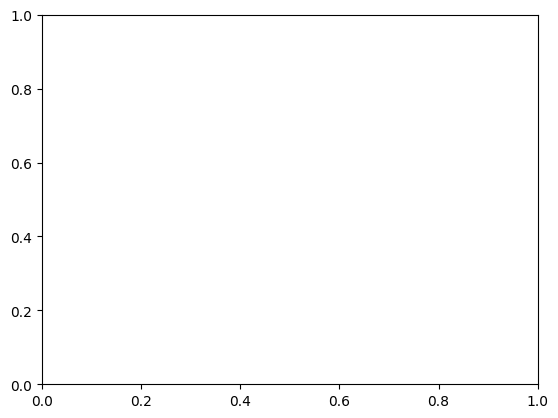

In [21]:
from IPython.display import HTML
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

def filter_nans(frames):
    return frames[~np.isnan(frames).all(axis=(-2,-1))]

ds = tf.data.TFRecordDataset(TRAIN_FILENAMES, num_parallel_reads=tf.data.AUTOTUNE, compression_type='GZIP')
ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
print(ds)
for x in ds:
    temp = x['coordinates'].numpy()
    if not len(filter_nans(temp[:,LHAND])) == 0:
        break

edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]

fig, ax = plt.subplots()

def plot_frame(frame, edges=[], idxs=[]):

    frame[np.isnan(frame)] = 0
    x = list(frame[...,0])
    y = list(frame[...,1])
    if len(idxs) == 0:
        idxs = list(range(len(x)))
    ax.clear()
    ax.scatter(x, y, color='dodgerblue')
    for i in range(len(x)):
        ax.text(x[i], y[i], idxs[i])

    for edge in edges:
        ax.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], color='salmon')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

def animate_frames(frames, edges=[], idxs=[]):
    anim = FuncAnimation(fig, lambda frame: plot_frame(frame, edges, idxs), frames=frames, interval=100)
    return HTML(anim.to_jshtml())

In [22]:
# Animate the frames
animate_frames(filter_nans(temp[:,LHAND]),edges=edges)

In [23]:
animate_frames(filter_nans(augment_fn(temp,always=True).numpy()[:,RHAND]),edges=edges)

/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py:1762: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(


In [24]:
animate_frames(filter_nans(temp[:,POINT_LANDMARKS]))

In [25]:
animate_frames(filter_nans(augment_fn(temp,always=True).numpy()[:,POINT_LANDMARKS]), idxs=POINT_LANDMARKS)

In [26]:
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn

class LateDropout(tf.keras.layers.Layer):
    def __init__(self, rate, noise_shape=None, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.start_step = start_step
        self.dropout = tf.keras.layers.Dropout(rate, noise_shape=noise_shape)

    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(0, dtype="int64", aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        x = tf.cond(self._train_counter < self.start_step, lambda:inputs, lambda:self.dropout(inputs, training=training))
        if training:
          self._train_counter.assign_add(1)
        return x

class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self,
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer='glorot_uniform',
        name='', **kwargs):
        super().__init__(name=name,**kwargs)
        self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='valid',
                            use_bias=use_bias,
                            depthwise_initializer=depthwise_initializer,
                            name=name + '_dwconv')
        self.supports_masking = True

    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x

def Conv1DBlock(channel_size,
          kernel_size,
          dilation_rate=1,
          drop_rate=0.0,
          expand_ratio=2,
          se_ratio=0.25,
          activation='swish',
          name=None):
    '''
    efficient conv1d block, @hoyso48
    '''
    if name is None:
        name = str(tf.keras.backend.get_uid("mbblock"))
    # Expansion phase
    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(inputs)

        # Depthwise Convolution
        x = CausalDWConv1D(kernel_size,
            dilation_rate=dilation_rate,
            use_bias=False,
            name=name + '_dwconv')(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

        x  = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)

        if (channels_in == channel_size):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply

In [40]:
class SparseMHSA(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, sparsity_threshold=0.1,
                 block_size=32, use_block_sparse=True, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

        # 稀疏性参数
        self.sparsity_threshold = sparsity_threshold
        self.block_size = block_size
        self.use_block_sparse = use_block_sparse

    def call(self, inputs, mask=None, training=None):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]

        # QKV投影
        qkv = self.qkv(inputs)
        qkv = tf.reshape(qkv, [batch_size, seq_len, self.num_heads, 3 * self.head_dim])
        qkv = tf.transpose(qkv, [0, 2, 1, 3])  # [batch, heads, seq_len, 3*head_dim]

        # 分离QKV
        q, k, v = tf.split(qkv, [self.head_dim, self.head_dim, self.head_dim], axis=-1)

        # 计算注意力分数
        attn = tf.matmul(q, k, transpose_b=True) * self.scale  # [batch, heads, seq_len, seq_len]

        # 应用稀疏注意力机制
        if self.use_block_sparse and seq_len >= self.block_size:
            # 块稀疏实现
            attn = self._apply_block_sparsity(attn, seq_len)
        else:
            # 阈值稀疏实现
            attn = self._apply_threshold_sparsity(attn)

        # 应用掩码(如果提供)

        if mask is not None:
          # 扩展掩码以适合注意力张量 [batch, 1, 1, seq_len]
          mask = mask[:, tf.newaxis, tf.newaxis, :]
          mask = tf.cast(mask, attn.dtype)  # 转换为与attn相同的数据类型
          adder = (1.0 - mask) * -1e9
          attn = attn + tf.cast(adder, attn.dtype)  # 确保adder与attn类型一致
          # 应用softmax和dropout
          attn = tf.nn.softmax(attn, axis=-1)
          attn = self.drop1(attn, training=training)

        # 应用注意力权重
        x = tf.matmul(attn, v)  # [batch, heads, seq_len, head_dim]

        # 重新格式化输出
        x = tf.transpose(x, [0, 2, 1, 3])  # [batch, seq_len, heads, head_dim]
        x = tf.reshape(x, [batch_size, seq_len, self.dim])

        # 最终投影
        x = self.proj(x)

        return x

    def _apply_threshold_sparsity(self, attn):
        """应用简单的阈值稀疏"""
        # 创建掩码，忽略绝对值小于阈值的注意力分数
        sparse_mask = tf.abs(attn) < self.sparsity_threshold
        attn = tf.where(sparse_mask, tf.ones_like(attn) * -1e9, attn)
        return attn

    def _apply_block_sparsity(self, attn, seq_len):
        """应用块稀疏性"""
        # 计算块数
        num_blocks = (seq_len + self.block_size - 1) // self.block_size

        # 重塑为块格式
        # [batch, heads, num_blocks, block_size, num_blocks, block_size]
        attn_shape = tf.shape(attn)
        padded_seq_len = num_blocks * self.block_size

        # 如果需要填充序列长度以匹配整数个块
        if padded_seq_len != seq_len:
            padding = padded_seq_len - seq_len
            attn = tf.pad(attn, [[0, 0], [0, 0], [0, 0], [0, padding]])
            attn = tf.pad(attn, [[0, 0], [0, 0], [0, padding], [0, 0]])

        # 重新整形为块
        attn_reshaped = tf.reshape(
            attn,
            [attn_shape[0], attn_shape[1], num_blocks, self.block_size, num_blocks, self.block_size]
        )

        # 计算块间注意力平均值
        block_attn = tf.reduce_mean(attn_reshaped, axis=[3, 5])  # [batch, heads, num_blocks, num_blocks]

        # 确定要保留的块
        _, top_indices = tf.math.top_k(tf.reshape(block_attn, [attn_shape[0], attn_shape[1], num_blocks * num_blocks]),
                               k=tf.cast(0.3 * tf.cast(num_blocks * num_blocks, tf.float32), tf.int32))
        # 创建块掩码
        block_mask = tf.zeros([attn_shape[0], attn_shape[1], num_blocks, num_blocks], dtype=tf.float32)

        # 对于每个批次和头，设置要保留的块
        batch_indices = tf.repeat(tf.range(attn_shape[0]), repeats=[attn_shape[1] * tf.shape(top_indices)[2]])
        head_indices = tf.tile(
            tf.repeat(tf.range(attn_shape[1]), repeats=[tf.shape(top_indices)[2]]),
            [attn_shape[0]]
        )
        flat_indices = tf.reshape(top_indices, [-1])

        # 展开的更新索引
        indices = tf.stack([batch_indices, head_indices, flat_indices // num_blocks, flat_indices % num_blocks], axis=1)
        updates = tf.ones([tf.shape(indices)[0]], dtype=tf.float32)

        block_mask = tf.tensor_scatter_nd_update(
            block_mask,
            indices,
            updates
        )

        # 扩展块掩码到完整的注意力张量
        block_mask = tf.repeat(tf.repeat(block_mask, repeats=[self.block_size], axis=2), repeats=[self.block_size], axis=3)

        # 应用掩码
        sparse_mask = block_mask < 0.5  # 转换为布尔掩码
        attn = tf.where(sparse_mask, tf.ones_like(attn) * -1e9, attn)

        # 如果有填充，截断回原始大小
        if padded_seq_len != seq_len:
            attn = attn[:, :, :seq_len, :seq_len]

        return attn

def TransformerBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2,
                    activation='swish', sparsity_threshold=0.7, block_size=64, use_block_sparse=True):
    def apply(inputs):
        x = inputs
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = SparseMHSA(
            dim=dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            sparsity_threshold=sparsity_threshold,
            block_size=block_size,
            use_block_sparse=use_block_sparse
        )(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        # FFN部分
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x
    return apply

In [32]:
def get_model(max_len=64, dropout_step=0, dim=192):
    inp = tf.keras.Input((max_len,CHANNELS))
    x = tf.keras.layers.Masking(mask_value=PAD,input_shape=(max_len,CHANNELS))(inp)
    ksize = 17
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    if dim == 384: #for the 4x sized model
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

    x = tf.keras.layers.Dense(dim*2,activation=None,name='top_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = LateDropout(0.8, start_step=dropout_step)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES,name='classifier')(x)
    return tf.keras.Model(inp, x)

model = get_model()
y = model(temp_train[0])
tf.keras.losses.CategoricalCrossentropy(from_logits=True)(temp_train[1],y)

<tf.Tensor: shape=(), dtype=float32, numpy=5.8411236>

In [33]:
#check supports_masking
for x in model.layers:
    if not x.supports_masking:
        print(x.supports_masking, x.name)

In [37]:
STRATEGY, N_REPLICAS, IS_TPU = get_strategy()
def train_fold(CFG, fold, train_files, valid_files=None, strategy=STRATEGY, summary=True):
    seed_everything(CFG.seed)
    tf.keras.backend.clear_session()
    gc.collect()
    tf.config.optimizer.set_jit(True)

    if CFG.fp16:
        try:
            policy = mixed_precision.Policy('mixed_bfloat16')
            mixed_precision.set_global_policy(policy)
        except:
            policy = mixed_precision.Policy('mixed_float16')
            mixed_precision.set_global_policy(policy)
    else:
        policy = mixed_precision.Policy('float32')
        mixed_precision.set_global_policy(policy)

    if fold != 'all':
        train_ds = get_tfrec_dataset(train_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=True, augment=True, repeat=True, shuffle=32768)
        valid_ds = get_tfrec_dataset(valid_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=False, repeat=False, shuffle=False)
    else:
        train_ds = get_tfrec_dataset(train_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=False, augment=True, repeat=True, shuffle=32768)
        valid_ds = None
        valid_files = []

    num_train = count_data_items(train_files)
    num_valid = count_data_items(valid_files)
    steps_per_epoch = num_train//CFG.batch_size
    with strategy.scope():
        dropout_step = CFG.dropout_start_epoch * steps_per_epoch
        model = get_model(max_len=CFG.max_len, dropout_step=dropout_step, dim=CFG.dim)

        schedule = OneCycleLR(CFG.lr, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=CFG.resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min, decay_type=CFG.decay_type, warmup_type='linear')
        decay_schedule = OneCycleLR(CFG.lr*CFG.weight_decay, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=CFG.resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min*CFG.weight_decay, decay_type=CFG.decay_type, warmup_type='linear')

        awp_step = CFG.awp_start_epoch * steps_per_epoch
        if CFG.fgm:
            model = FGM(model.input, model.output, delta=CFG.awp_lambda, eps=0., start_step=awp_step)
        elif CFG.awp:
            model = AWP(model.input, model.output, delta=CFG.awp_lambda, eps=0., start_step=awp_step)

        opt = tfa.optimizers.RectifiedAdam(learning_rate=schedule, weight_decay=decay_schedule, sma_threshold=4)#, clipvalue=1.)
        opt = tfa.optimizers.Lookahead(opt,sync_period=5)

        model.compile(
            optimizer=opt,
            loss=[tf.keras.losses.CategoricalCrossentropy(from_logits=True,label_smoothing=0.1)],# [tf.keras.losses.CategoricalCrossentropy(from_logits=True)]
            metrics=[
                [
                tf.keras.metrics.CategoricalAccuracy(),
                ],
            ],
            steps_per_execution=steps_per_epoch,
        )

    if summary:
        print()
        model.summary()
        print()
        print(train_ds, valid_ds)
        print()
        schedule.plot()
        print()
        init=False
    print(f'---------fold{fold}---------')
    print(f'train:{num_train} valid:{num_valid}')
    print()

    if CFG.resume:
        print(f'resume from epoch{CFG.resume}')
        model.load_weights(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-last.h5')
        if train_ds is not None:
            model.evaluate(train_ds.take(steps_per_epoch))
        if valid_ds is not None:
            model.evaluate(valid_ds)

    logger = tf.keras.callbacks.CSVLogger(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-logs.csv')
    sv_loss = tf.keras.callbacks.ModelCheckpoint(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-best.h5', monitor='val_loss', verbose=0, save_best_only=True,
                save_weights_only=True, mode='min', save_freq='epoch')
    snap = Snapshot(f'{CFG.output_dir}/{CFG.comment}-fold{fold}', CFG.snapshot_epochs)
    swa = SWA(f'{CFG.output_dir}/{CFG.comment}-fold{fold}', CFG.swa_epochs, strategy=strategy, train_ds=train_ds, valid_ds=valid_ds, valid_steps=-(num_valid//-CFG.batch_size))
    callbacks = []
    if CFG.save_output:
        callbacks.append(logger)
        callbacks.append(snap)
        callbacks.append(swa)
        if fold != 'all':
            callbacks.append(sv_loss)

    history = model.fit(
        train_ds,
        epochs=CFG.epoch-CFG.resume,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        validation_data=valid_ds,
        verbose=CFG.verbose,
        validation_steps=-(num_valid//-CFG.batch_size)
    )

    if CFG.save_output:
        try:
            model.load_weights(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-best.h5')
        except:
            pass
    if fold != 'all':
        cv = model.evaluate(valid_ds,verbose=CFG.verbose,steps=-(num_valid//-CFG.batch_size))
    else:
        cv = None

    return model, cv, history

def train_folds(CFG, folds, strategy=STRATEGY, summary=True):
    for fold in folds:
        if fold != 'all':
            all_files = TRAIN_FILENAMES
            train_files = [x for x in all_files if f'fold{fold}' not in x]
            valid_files = [x for x in all_files if f'fold{fold}' in x]
        else:
            train_files = TRAIN_FILENAMES
            valid_files = None

        train_fold(CFG, fold, train_files, valid_files, strategy=strategy, summary=summary)
    return

connecting to TPU...
TPU not available, falling back to GPU/CPU
Using CPU
REPLICAS: 1


In [38]:
class CFG:
    n_splits = 5
    save_output = True
    output_dir = '.'

    seed = 42
    verbose = 2 #0) silent 1) progress bar 2) one line per epoch

    max_len = 384
    replicas = 8
    lr = 5e-4 * replicas
    weight_decay = 0.1
    lr_min = 1e-6
    epoch = 300 #400
    warmup = 0
    batch_size = 64 * replicas
    snapshot_epochs = []
    swa_epochs = [] #list(range(epoch//2,epoch+1))

    fp16 = True
    fgm = False
    awp = True
    awp_lambda = 0.2
    awp_start_epoch = 15
    dropout_start_epoch = 15
    resume = 0
    decay_type = 'cosine'
    dim = 192
    comment = f'islr-fp16-192-8-seed{seed}'


Model: "awp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 708)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 384, 708)     0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Dense)              (None, 384, 192)     135936      ['masking[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 384, 192)     768         ['stem_conv[0][0]']              
                                                                                               

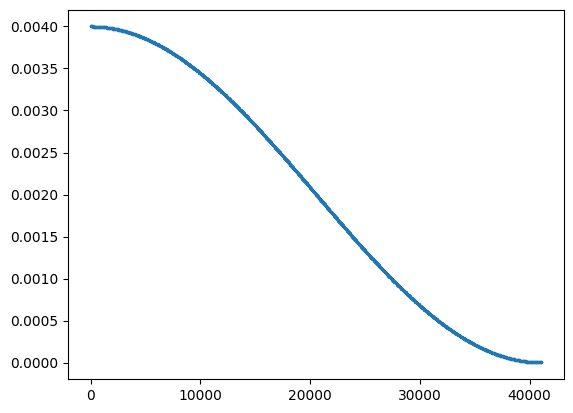


---------fold0---------
train:70611 valid:23866

Epoch 1/300


In [ ]:
train_folds(CFG, [0])

In [ ]:
# CFG.seed = 42
# CFG.comment = f'islr-fp16-192-8-seed{CFG.seed}'
# train_folds(CFG, ['all'], summary=False)

In [ ]:
# CFG.seed = 43
# CFG.comment = f'islr-fp16-192-8-seed{CFG.seed}'
# train_folds(CFG, ['all'], summary=False)

In [ ]:
# CFG.seed = 44
# CFG.comment = f'islr-fp16-192-8-seed{CFG.seed}'
# train_folds(CFG, ['all'], summary=False)

In [ ]:
# CFG.seed = 45
# CFG.comment = f'islr-fp16-192-8-seed{CFG.seed}'
# train_folds(CFG, ['all'], summary=False)